In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc
import datetime
from datetime import timedelta
import matplotlib.dates as mdates

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D, InputLayer

from scipy import ndimage, misc

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler

Using TensorFlow backend.


In [2]:
# Change presentation settings
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["figure.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14

In [3]:
#runs = [302634, 302635, 305814, 306121, 306122, 306125, 306126]
runs = [306121, 306122, 306125, 306126]
lumi_directory = data_directory = "./lumi"
rates_directory = "./rates"

Reading instantaneous luminosities from the cvs file produced with brilcalc and saving into a pandas dataframe:

In [4]:
df_rates = pd.DataFrame()
int_lumi2 = pd.DataFrame()
for run in runs:
    print("Loading %s" % run)
    path = "%s/lumi_%s.csv" % (lumi_directory, run)
    int_lumi2 = int_lumi2.append(pd.read_csv(path,
        names=["runfill", "ls", "time", "beamstatus", "energy", "delivered", "recorded", "avgpu", "source"]), 
        ignore_index=True);    
    path = "%s/dt_rates_%s.csv" % (rates_directory, run)
    df_rates = df_rates.append(pd.read_csv(path, 
        names=["run", "time", "board", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]), 
        ignore_index=True);
print("Done.")

Loading 306121
Loading 306122
Loading 306125
Loading 306126
Done.


Dropping useless rows from the dataframe:

In [6]:
#print int_lumi2
#print df_rates

In [7]:
int_lumi2["source"] = int_lumi2["source"].astype('str')
int_lumi2 = int_lumi2[int_lumi2["source"] != "nan"]
int_lumi2 = int_lumi2[int_lumi2["source"] != "source"]

Splitting run:fill and the start and end luminosities:

In [8]:
int_lumi2['run'], int_lumi2['fill'] = int_lumi2['runfill'].str.split(':', 1).str
int_lumi2['ls_start'], int_lumi2['ls_end'] = int_lumi2['ls'].str.split(':', 1).str

In [9]:
#print int_lumi2

Converting run to integer and luminosities to float:

In [10]:
int_lumi2["run"] = int_lumi2["run"].astype('int')
int_lumi2["delivered"] = int_lumi2["delivered"].astype('float64')
int_lumi2["recorded"] = int_lumi2["recorded"].astype('float64') 

Converting time stamp to datetime:

In [11]:
pd.to_datetime(int_lumi2["time"])

2      2017-11-03 13:10:09
3      2017-11-03 13:10:31
4      2017-11-03 13:10:54
5      2017-11-03 13:11:18
6      2017-11-03 13:11:41
7      2017-11-03 13:12:04
8      2017-11-03 13:12:27
9      2017-11-03 13:12:51
10     2017-11-03 13:13:14
11     2017-11-03 13:13:37
12     2017-11-03 13:14:01
13     2017-11-03 13:14:24
14     2017-11-03 13:14:47
15     2017-11-03 13:15:11
16     2017-11-03 13:15:34
17     2017-11-03 13:15:57
18     2017-11-03 13:16:21
19     2017-11-03 13:16:44
20     2017-11-03 13:17:07
21     2017-11-03 13:17:31
22     2017-11-03 13:17:54
23     2017-11-03 13:18:17
24     2017-11-03 13:18:40
25     2017-11-03 13:19:04
26     2017-11-03 13:19:27
27     2017-11-03 13:19:50
28     2017-11-03 13:20:14
29     2017-11-03 13:20:37
30     2017-11-03 13:21:00
31     2017-11-03 13:21:24
               ...        
3743   2017-11-04 13:17:23
3744   2017-11-04 13:17:47
3745   2017-11-04 13:18:10
3746   2017-11-04 13:18:33
3747   2017-11-04 13:18:57
3748   2017-11-04 13:19:20
3

Creating end time column from the start time:

In [12]:
def addTimeOffSet(data):
    startdate = data.time
    enddate = pd.to_datetime(startdate) + pd.DateOffset(seconds=23)
    return enddate

In [13]:
int_lumi2["time_end"] = int_lumi2["time"]
int_lumi2["time_end"] = int_lumi2.apply(addTimeOffSet, axis=1);

In [14]:
#print int_lumi2["time"], int_lumi2["time_end"]

Converting time stamp to datetime for plotting:

In [15]:
def transform_time(data):
    from datetime import datetime
    time_str = data.time
    #print time_str
    datetime_object = datetime.strptime(time_str, "%m/%d/%y %H:%M:%S")
    #print datetime_object
    return datetime_object
int_lumi2["time"] = int_lumi2.apply(transform_time, axis=1);

In [16]:
def plot_inst_lumi(x_val, y_val, z_val, title):
    import datetime
    import matplotlib.dates as mdates
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Inst. Lumi. [E30 Hz/cm$^2$]")
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(x_val, y_val, 'ro-')
    plt.plot(x_val, z_val, 'bo-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

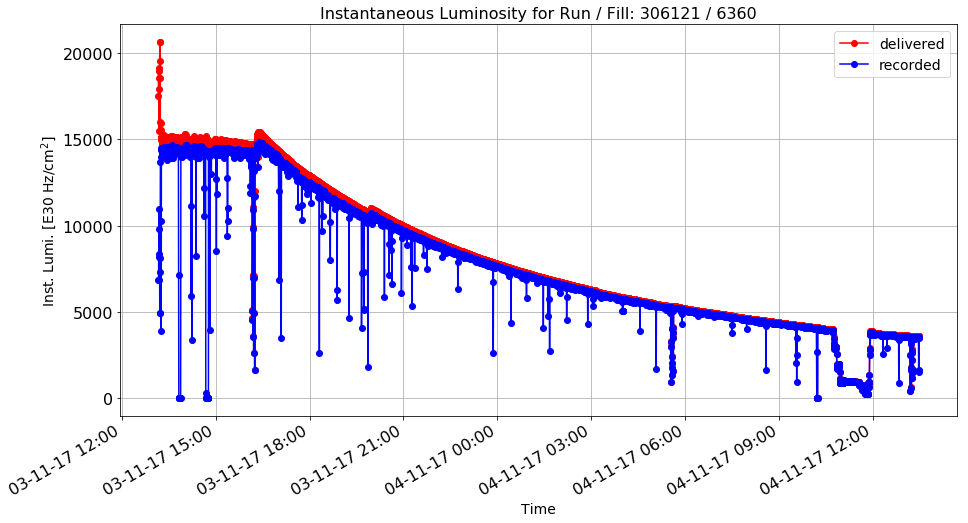

In [17]:
plot_inst_lumi(int_lumi2["time"], int_lumi2["delivered"], int_lumi2["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (int_lumi2["run"].iloc[2], int_lumi2["fill"].iloc[2])))

Reading rates from the cvs files produced by the script and saving the informations into a new pandas dataframe:

In [18]:
pd.to_datetime(df_rates["time"])
df_rates["run"] = df_rates["run"].astype('int')
#df_rates["run"].dtype

Converting and splitting:

In [19]:
df_rates['wheel'], df_rates['sector'] = df_rates['board'].str.split('_', 1).str
df_rates["wheel"] = df_rates["wheel"].astype(str)
df_rates["sector"] = df_rates["sector"].astype(str)

In [20]:
#print df_rates["DT1"]

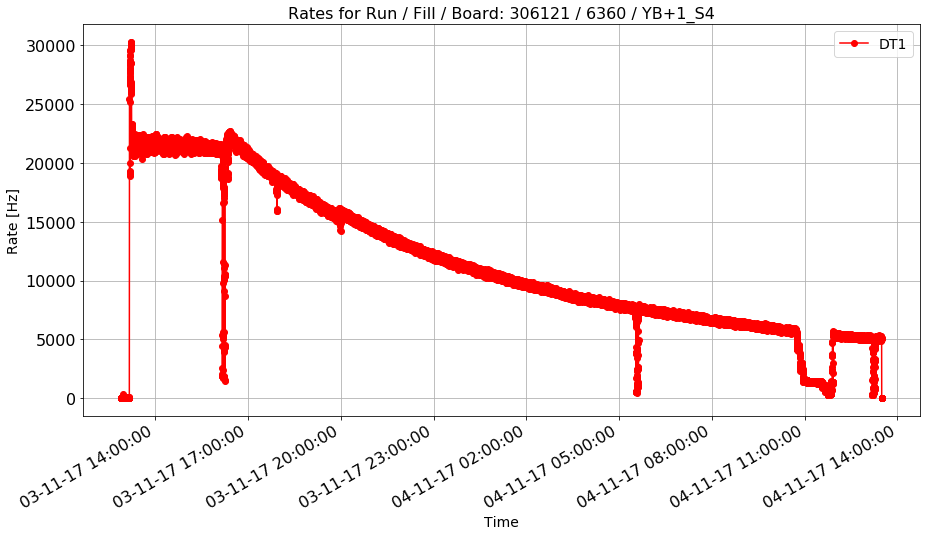

In [21]:
def plot_rate_vs_time(df, x_val, y_val, z_val, title):
    df_temp = df.copy()
    crit = df_temp["board"] == z_val
    df_temp = df_temp[crit]
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Rate [Hz]")
    ax.xaxis_date()
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], 'ro-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

plot_rate_vs_time(df_rates, "time", "DT1", "YB+1_S4", "Rates for Run / Fill / Board: %s / %s / %s" % 
                  (int_lumi2["run"].iloc[2], int_lumi2["fill"].iloc[2], "YB+1_S4"))

In [22]:
df_rates["ls"] = -1
df_rates["start"] = -1
df_rates["end"] = -1
df_rates["lumi"] = -1.0
df_rates["score"] = -1
df_rates["errorRPC1"] = -1.0
df_rates["errorRPC2"] = -1.0
df_rates["errorRPC3"] = -1.0
df_rates["errorRPC4"] = -1.0
df_rates["errorDT1"] = -1.0
df_rates["errorDT2"] = -1.0
df_rates["errorDT3"] = -1.0
df_rates["errorDT4"] = -1.0
df_rates["errorDT5"] = -1.0
#print df_rates["ls"]

Associating a LS and an instantaneous luminosity to each rate:

In [70]:
boundaries = pd.DataFrame(columns=["run", "start", "end"])
for i in runs:
    start = int_lumi2[int_lumi2["run"] == i]["time"]
    end = int_lumi2[int_lumi2["run"] == i]["time_end"]
    start =  start.reset_index(drop=True)
    end =  end.reset_index(drop=True)
    print i, start.iloc[0], end.iloc[-1]
    boundaries = boundaries.append({"run": i, "start": start.iloc[0], "end": end.iloc[-1]}, ignore_index = True)

306121 2017-11-03 13:10:09 2017-11-03 13:53:15
306122 2017-11-03 13:53:18 2017-11-03 14:46:31
306125 2017-11-03 14:46:12 2017-11-04 10:14:29
306126 2017-11-04 10:14:24 2017-11-04 13:29:02


In [71]:
print boundaries

      run               start                 end
0  306121 2017-11-03 13:10:09 2017-11-03 13:53:15
1  306122 2017-11-03 13:53:18 2017-11-03 14:46:31
2  306125 2017-11-03 14:46:12 2017-11-04 10:14:29
3  306126 2017-11-04 10:14:24 2017-11-04 13:29:02


In [ ]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        result = (start <= x <= end)
        return result
    else:
        return start <= x or x <= end

def assignLS(df, boundaries):
    ls = 1
    j = 1
    time0 = boundaries["start"].iloc[0]
    run0 = boundaries["run"].iloc[0]
    for index, row in df.iterrows():
        j = j + 1
        run = row["run"]
        if(run > run0): 
            time0 = boundaries[boundaries["run"] == run]["time"]
        time1 = pd.to_datetime(time0) + pd.DateOffset(seconds=23)
        timeF = boundaries["end"].iloc[-1]
        rate_time = pd.to_datetime(row["time"])
        print run, rate_time, time0, time1, timeF
        board = row["board"]
        if (board != "YB0_S1"): #remove after developing
            continue
        if ((rate_time < time0) | (rate_time > timeF)):
            continue
        print run, rate_time, time0, time1
        if time_in_range(time0, time1, rate_time):
            df.set_value(index, 'ls', ls)
            print j, ls
        else:
            ls = ls + 1
            df.set_value(index, 'ls', ls)
            print j, ls
            time0 = time1
        
assignLS(df_rates, boundaries)

 306121 2017-11-03 12:53:43.588589 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:43.588589 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:43.588589 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:43.588589 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:43.588589 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:43.588589 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:43.588589 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:43.588589 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:43.588589 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:43.588589 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:43.588589 2017-11-03 13:10:09 2017-

306121 2017-11-03 12:53:47.951392 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:47.951392 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:47.951392 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:47.951392 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:47.951392 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:47.951392 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:47.951392 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:47.951392 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:47.951392 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:47.951392 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:47.951392 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:53:50.145633 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:50.145633 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:52.347091 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:52.347091 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:52.347091 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:52.347091 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:52.347091 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:52.347091 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:52.347091 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:52.347091 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:53:52.347091 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:54:18.777111 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:18.777111 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:18.777111 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:18.777111 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:18.777111 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:18.777111 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:18.777111 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:18.777111 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:18.777111 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:18.777111 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:18.777111 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:54:27.680225 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:27.680225 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:27.680225 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:27.680225 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:27.680225 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:27.680225 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:27.680225 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:27.680225 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:27.680225 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:27.680225 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:27.680225 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:54:36.517525 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:36.517525 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:36.517525 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:36.517525 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:38.746381 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:38.746381 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:38.746381 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:38.746381 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:38.746381 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:38.746381 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:38.746381 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:54:40.985267 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:43.208334 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:43.208334 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:43.208334 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:43.208334 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:43.208334 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:43.208334 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:43.208334 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:43.208334 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:43.208334 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:43.208334 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:54:49.832693 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:49.832693 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:49.832693 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:49.832693 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:49.832693 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:49.832693 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:49.832693 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:49.832693 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:49.832693 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:49.832693 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:54:49.832693 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:55:16.272483 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:16.272483 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:16.272483 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:16.272483 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:16.272483 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:16.272483 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:16.272483 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:16.272483 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:16.272483 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:16.272483 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:16.272483 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:55:25.222356 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:25.222356 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:25.222356 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:25.222356 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:25.222356 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:25.222356 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:27.445504 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:27.445504 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:27.445504 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:27.445504 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:27.445504 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:55:34.202231 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:34.202231 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:34.202231 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:34.202231 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:34.202231 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:34.202231 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:34.202231 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:34.202231 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:34.202231 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:34.202231 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:34.202231 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:55:40.926987 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:40.926987 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:40.926987 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:40.926987 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:40.926987 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:40.926987 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:40.926987 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:40.926987 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:40.926987 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:40.926987 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:40.926987 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:55:47.615740 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:47.615740 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:47.615740 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:47.615740 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:47.615740 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:47.615740 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:47.615740 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:47.615740 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:47.615740 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:47.615740 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:55:47.615740 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:56:18.393648 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:18.393648 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:18.393648 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:18.393648 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:18.393648 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:18.393648 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:18.393648 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:18.393648 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:18.393648 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:18.393648 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:18.393648 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:56:29.344742 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:29.344742 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:29.344742 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:29.344742 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:29.344742 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:29.344742 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:29.344742 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:29.344742 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:29.344742 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:29.344742 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:29.344742 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:56:38.102369 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:38.102369 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:38.102369 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:38.102369 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:38.102369 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:38.102369 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:38.102369 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:38.102369 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:38.102369 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:38.102369 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:38.102369 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:56:44.657366 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:44.657366 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:44.657366 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:46.859823 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:46.859823 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:46.859823 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:46.859823 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:46.859823 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:46.859823 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:46.859823 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:46.859823 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:56:51.316006 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:51.316006 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:51.316006 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:51.316006 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:51.316006 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:51.316006 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:51.316006 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:51.316006 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:51.316006 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:51.316006 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:56:51.316006 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:57:19.943141 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:19.943141 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:19.943141 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:19.943141 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:19.943141 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:19.943141 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:19.943141 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:19.943141 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:19.943141 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:19.943141 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:19.943141 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:57:31.052262 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:31.052262 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:31.052262 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:31.052262 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:31.052262 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:31.052262 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:31.052262 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:31.052262 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:31.052262 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:31.052262 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:31.052262 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:57:37.584866 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:37.584866 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:37.584866 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:37.584866 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:37.584866 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:37.584866 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:37.584866 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:37.584866 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:37.584866 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:37.584866 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:37.584866 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:57:46.412706 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:46.412706 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:46.412706 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:46.412706 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:46.412706 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:46.412706 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:46.412706 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:46.412706 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:46.412706 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:46.412706 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:46.412706 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:57:53.029174 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:53.029174 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:53.029174 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:53.029174 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:53.029174 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:53.029174 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:53.029174 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:53.029174 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:53.029174 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:53.029174 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:57:53.029174 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:58:17.147491 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:17.147491 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:17.147491 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:17.147491 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:17.147491 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:17.147491 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:17.147491 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:17.147491 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:17.147491 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:17.147491 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:17.147491 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:58:23.735882 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:23.735882 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:23.735882 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:23.735882 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:23.735882 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:23.735882 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:23.735882 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:23.735882 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:23.735882 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:23.735882 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:23.735882 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:58:30.299828 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:30.299828 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:30.299828 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:30.299828 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:30.299828 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:30.299828 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:30.299828 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:30.299828 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:30.299828 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:30.299828 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:30.299828 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:58:36.853519 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:36.853519 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:36.853519 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:36.853519 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:36.853519 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:36.853519 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:36.853519 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:36.853519 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:36.853519 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:36.853519 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:36.853519 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:58:45.683751 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:45.683751 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:45.683751 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:45.683751 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:45.683751 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:45.683751 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:45.683751 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:45.683751 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:45.683751 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:45.683751 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:45.683751 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:58:52.220778 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:52.220778 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:52.220778 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:52.220778 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:52.220778 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:52.220778 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:52.220778 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:52.220778 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:52.220778 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:52.220778 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:58:52.220778 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:59:18.718444 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:18.718444 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:18.718444 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:18.718444 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:18.718444 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:18.718444 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:18.718444 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:18.718444 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:18.718444 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:18.718444 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:18.718444 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:59:25.306257 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:25.306257 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:25.306257 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:25.306257 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:25.306257 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:25.306257 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:25.306257 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:25.306257 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:25.306257 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:25.306257 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:25.306257 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:59:36.398889 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:36.398889 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:36.398889 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:36.398889 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:36.398889 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:36.398889 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:36.398889 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:36.398889 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:36.398889 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:36.398889 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:36.398889 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:59:45.235101 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:45.235101 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:45.235101 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:45.235101 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:45.235101 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:45.235101 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:45.235101 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:45.235101 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:45.235101 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:45.235101 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:45.235101 2017-11-03 13:10:09 2017-1

306121 2017-11-03 12:59:51.838066 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:51.838066 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:51.838066 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:51.838066 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:51.838066 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:51.838066 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:51.838066 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:51.838066 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:51.838066 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:51.838066 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 12:59:51.838066 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:00:18.516471 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:18.516471 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:18.516471 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:18.516471 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:18.516471 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:18.516471 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:18.516471 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:18.516471 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:18.516471 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:18.516471 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:18.516471 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:00:22.944903 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:22.944903 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:22.944903 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:22.944903 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:22.944903 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:22.944903 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:22.944903 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:22.944903 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:22.944903 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:22.944903 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:22.944903 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:00:29.575816 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:29.575816 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:29.575816 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:29.575816 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:29.575816 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:29.575816 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:29.575816 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:29.575816 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:29.575816 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:29.575816 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:29.575816 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:00:34.042873 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:34.042873 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:34.042873 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:34.042873 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:34.042873 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:34.042873 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:34.042873 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:34.042873 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:34.042873 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:34.042873 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:34.042873 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:00:40.654981 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:40.654981 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:40.654981 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:40.654981 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:40.654981 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:42.841831 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:42.841831 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:42.841831 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:42.841831 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:42.841831 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:42.841831 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:00:49.454228 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:49.454228 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:51.653198 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:51.653198 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:51.653198 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:51.653198 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:51.653198 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:51.653198 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:51.653198 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:51.653198 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:00:51.653198 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:01:16.427810 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:16.427810 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:16.427810 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:16.427810 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:16.427810 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:16.427810 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:16.427810 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:16.427810 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:16.427810 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:16.427810 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:16.427810 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:01:23.004636 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:23.004636 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:23.004636 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:23.004636 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:23.004636 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:23.004636 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:23.004636 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:23.004636 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:23.004636 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:23.004636 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:23.004636 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:01:25.202145 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:25.202145 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:25.202145 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:25.202145 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:27.394106 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:27.394106 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:27.394106 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:27.394106 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:27.394106 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:27.394106 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:27.394106 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:01:31.783652 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:31.783652 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:31.783652 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:31.783652 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:31.783652 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:31.783652 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:31.783652 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:31.783652 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:31.783652 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:31.783652 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:31.783652 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:01:40.524195 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:40.524195 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:40.524195 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:40.524195 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:40.524195 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:40.524195 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:40.524195 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:40.524195 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:40.524195 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:40.524195 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:40.524195 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:01:51.473362 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:51.473362 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:51.473362 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:51.473362 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:51.473362 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:51.473362 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:51.473362 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:51.473362 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:51.473362 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:51.473362 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:01:51.473362 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:02:15.580301 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:15.580301 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:15.580301 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:15.580301 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:15.580301 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:15.580301 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:15.580301 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:15.580301 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:15.580301 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:15.580301 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:15.580301 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:02:24.380533 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:24.380533 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:24.380533 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:24.380533 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:24.380533 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:24.380533 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:24.380533 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:24.380533 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:24.380533 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:24.380533 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:24.380533 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:02:31.045244 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:31.045244 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:31.045244 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:31.045244 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:31.045244 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:31.045244 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:31.045244 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:31.045244 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:31.045244 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:31.045244 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:31.045244 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:02:35.425138 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:35.425138 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:35.425138 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:35.425138 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:35.425138 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:35.425138 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:35.425138 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:35.425138 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:35.425138 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:35.425138 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:35.425138 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:02:42.116157 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:42.116157 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:42.116157 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:42.116157 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:42.116157 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:42.116157 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:42.116157 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:42.116157 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:42.116157 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:42.116157 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:42.116157 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:02:53.134687 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:53.134687 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:53.134687 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:53.134687 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:53.134687 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:53.134687 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:53.134687 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:53.134687 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:53.134687 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:53.134687 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:02:53.134687 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:03:17.519530 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:17.519530 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:17.519530 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:19.817939 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:19.817939 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:19.817939 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:19.817939 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:19.817939 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:19.817939 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:19.817939 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:19.817939 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:03:26.395573 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:26.395573 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:26.395573 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:26.395573 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:26.395573 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:26.395573 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:26.395573 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:26.395573 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:26.395573 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:26.395573 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:26.395573 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:03:32.936892 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:32.936892 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:32.936892 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:32.936892 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:32.936892 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:32.936892 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:32.936892 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:32.936892 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:35.116850 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:35.116850 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:35.116850 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:03:41.800523 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:41.800523 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:41.800523 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:41.800523 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:41.800523 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:43.976098 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:43.976098 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:43.976098 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:43.976098 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:43.976098 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:43.976098 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:03:46.182472 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:46.182472 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:46.182472 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:46.182472 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:46.182472 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:46.182472 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:46.182472 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:46.182472 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:46.182472 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:46.182472 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:46.182472 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:03:52.828820 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:52.828820 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:52.828820 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:52.828820 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:52.828820 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:52.828820 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:52.828820 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:52.828820 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:52.828820 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:52.828820 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:03:52.828820 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:04:17.122199 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:17.122199 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:17.122199 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:17.122199 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:17.122199 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:17.122199 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:17.122199 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:17.122199 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:17.122199 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:17.122199 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:17.122199 2017-11-03 13:10:09 2017-1

306121 2017-11-03 13:04:28.101817 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:28.101817 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:28.101817 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:28.101817 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:28.101817 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:28.101817 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:28.101817 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:28.101817 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:28.101817 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:28.101817 2017-11-03 13:10:09 2017-11-03 13:10:32 2017-11-04 13:29:02
306121 2017-11-03 13:04:28.101817 2017-11-03 13:10:09 2017-1

In [40]:
print df_rates["board"], df_rates["time"]

0            YB0_S1
1            YB0_S2
2            YB0_S3
3            YB0_S4
4            YB0_S5
5            YB0_S6
6            YB0_S7
7            YB0_S8
8            YB0_S9
9           YB0_S10
10          YB0_S11
11          YB0_S12
12          YB+1_S1
13          YB+1_S2
14          YB+1_S3
15          YB+1_S4
16          YB+1_S5
17          YB+1_S6
18          YB+1_S7
19          YB+1_S8
20          YB+1_S9
21         YB+1_S10
22         YB+1_S11
23         YB+1_S12
24          YB+2_S1
25          YB+2_S2
26          YB+2_S3
27          YB+2_S4
28          YB+2_S5
29          YB+2_S6
             ...   
1640730     YB+2_S7
1640731     YB+2_S8
1640732     YB+2_S9
1640733    YB+2_S10
1640734    YB+2_S11
1640735    YB+2_S12
1640736     YB-1_S1
1640737     YB-1_S2
1640738     YB-1_S3
1640739     YB-1_S4
1640740     YB-1_S5
1640741     YB-1_S6
1640742     YB-1_S7
1640743     YB-1_S8
1640744     YB-1_S9
1640745    YB-1_S10
1640746    YB-1_S11
1640747    YB-1_S12
1640748     YB-2_S1


In [ ]:
def assignRate(df1, df2):
    for index1, row1 in df1.iterrows():
        run1 = row1["run"]
        rate_time = pd.to_datetime(row1["time"])
        time0 = df2["time"].iloc[0]
        if rate_time <= time0:
            continue
        for index2, row2 in df2.iterrows():
            run2 = row2["run"]
            if (run1 != run2):
                continue
            time1 = pd.to_datetime(row2["time"])
            time2 = pd.to_datetime(row2["time_end"])
            if time_in_range(time1, time2, rate_time):
                df1.set_value(index1, 'ls', row2["ls_start"])
                df1.set_value(index1, 'start', row2["time"])
                df1.set_value(index1, 'end', row2["time_end"])
                df1.set_value(index1, 'lumi', row2["delivered"])
                break
assignRate(df_rates, int_lumi2)

In [ ]:
#print df_rates[df_rates["ls"] >= 0]

In [ ]:
df_rates = df_rates[df_rates.ls > 0]
df_rates["wheel"].replace(regex=True,inplace=True,to_replace=r'YB',value=r'')
df_rates["sector"].replace(regex=True,inplace=True,to_replace=r'S',value=r'')
df_rates["wheel"] = df_rates["wheel"].astype('int')
df_rates["sector"] = df_rates["sector"].astype('int')
#print df_rates

Averaging the rates associated to the same LS:

In [ ]:
df_chamber = df_rates["board"]
df_chamber = df_chamber[df_chamber.duplicated() == False]
#print df_chamber

algos = ["RPC1", "RPC2", "RPC3", "RPC4","DT1", "DT2", "DT3", "DT4", "DT5"]
resultAverage = []
for x in algos:
    #print x
    for y in df_chamber:
        #print y
        rate = df_rates[df_rates["board"] == y]
        rule = rate.duplicated(subset=["run", "wheel", "sector", "ls", "lumi", "start", "end"])
        count = (rule == False).sum()
        #print count
        for i in range(count):
            #print rate[rate["ls"] == i]
            rate2 = rate[rate["ls"] == (i+1)]
            #print rate2[x]
            std = round(rate2[x].std(), 1)
            mean = round(rate2[x].mean(), 1)
            #print mean, std
            indexes = rate2[x].index
            #print i+1, indexes
            resultAverage.append([x, indexes, mean, std])
            #print resultAverage

In [ ]:
#print df_rates[df_rates["board"] == "YB0_S2"]["RPC1"]
#print df_rates[df_rates["board"] == "YB0_S1"]["RPC1"]

Removing the duplicates:

In [ ]:
rule = df_rates.duplicated(subset=["run", "wheel", "sector", "ls", "lumi"])
print "Duplicates:", rule.sum()
df_rates = df_rates[rule == False]

Assigning the average rates previously calculated to the remaining rows:

In [ ]:
for obj in resultAverage:
    #print obj[0], obj[1], obj[2], obj[3]
    for index, row in df_rates.iterrows():
        if index in obj[1]:
            #df_rates.set_value(index, obj[0], obj[2])
            df_rates.loc[index, obj[0]] = obj[2]
            df_rates.loc[index, "error"+obj[0]] = obj[3]

In [ ]:
for index, row in df_rates.iterrows():
    if row["board"] == "YB0_S1":
        print index, row["run"], row["board"], row["ls"], row["lumi"], row["RPC1"], row["errorRPC1"]

In [ ]:
def plot_rate_vs_ls(df, x_val, y_val, z_val, x_err, y_err, title_x, title_y, title, opt):
    df_temp = df.copy()
    crit = df_temp["board"] == z_val
    df_temp = df_temp[crit]
    fig, ax = plt.subplots()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], opt)
    plt.legend(loc="best")
    plt.errorbar(df_temp[x_val], df_temp[y_val], xerr=x_err, yerr=df_temp[y_err], fmt='ro', ecolor='r')
    plt.title(title)
    plt.show();

plot_rate_vs_ls(df_rates, "ls", "DT1", "YB+1_S4", 0, "errorDT1", "LS", "Rate [Hz]", "Rates for Run/Fill/Board "
                +int_lumi2["run:fill"][2]+":YB+1_S4", "ro-")
plot_rate_vs_ls(df_rates, "lumi", "DT1", "YB+1_S4", 0, "errorDT1", "Inst. Lumi. [E30 Hz/cm$^2$]", "Rate [Hz]", 
                "Rates for Run/Fill/Board "+int_lumi2["run:fill"][2]+":YB+1_S4", "ro")

In [ ]:
df_rates_new = pd.DataFrame(columns=["content","score"])
for index, row in df_rates.iterrows():
    for j in algos:
        #print j
        system = 0
        station = 0
        if (j.find("RPC") != -1):
            system = 1
        else:
            system = 2
        num = j.replace("RPC", "")
        num = num.replace("DT", "")
        station = int(num)
        array = np.array([system, row["wheel"], row["sector"], station, row[j], row["error"+j], row["lumi"]])
        #print array
        df_rates_new = df_rates_new.append({"content":array, "score":row["score"]}, ignore_index=True)

In [ ]:
#print df_rates_new

Creating train and test samples:

In [ ]:
# Set a random seed to reproduce the results
rng = np.random.RandomState(0)

anomalies = df_rates_new[df_rates_new.score == 1]
normalies = df_rates_new[df_rates_new.score == -1]
print("%s faults and %s good samples. In total: %s." %
      (len(anomalies), len(normalies), len(anomalies) + len(normalies)))

anomalies_train, anomalies_test = train_test_split(anomalies, test_size = 0.2, random_state=rng)
normalies_train, normalies_test = train_test_split(normalies, test_size = 0.2, random_state=rng)

neural_anomalies_train, neural_anomalies_val = train_test_split(anomalies_train, test_size = 0.2, random_state=rng)
neural_normalies_train, neural_normalies_val = train_test_split(normalies_train, test_size = 0.2, random_state=rng)

layers_train = pd.concat([anomalies_train, normalies_train])
layers_test = pd.concat([anomalies_test, normalies_test])

neural_train = pd.concat([neural_anomalies_train, neural_normalies_train])
neural_val = pd.concat([neural_anomalies_val, neural_normalies_val])

print("Number of anomalies in the train set: %s" % len(anomalies_test))
print("Number of normal in the train set: %s" % len(normalies_test))

In [ ]:
def get_roc_curve(test_df, models, working_point=None):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    for legend_label, model_score in models:
        false_positive_rate, true_positive_rate, _ = roc_curve(test_df["score"],
                                                               test_df[model_score])

        plt.plot(false_positive_rate, true_positive_rate, linewidth=2,
                 label=('%s, AUC: %s' % (legend_label,
                                         round(auc(false_positive_rate, true_positive_rate), 4))))
    if working_point:
        plt.plot(1-working_point[0],
                 working_point[1],
                 'o',
                 label="CNN working point")
    plt.title("ROC")
    plt.legend(loc='best')
    plt.ylabel('Sensitivity (TPR)')
    plt.xlabel('Fall-out (TNR)')
    plt.show();

In [ ]:
sess = tf.Session()
K.set_session(sess)

In [ ]:
def score_to_array(score):
    if score == -1:
        return np.asarray([1, 0])
    return np.asarray([0, 1])

def nn_generate_input():  
    return (np.array(np.concatenate(neural_train.content.values)).reshape(-1, 7),
            np.concatenate(neural_train["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(neural_val.content.values)).reshape(-1, 7),
            np.concatenate(neural_val["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(layers_test.content.values)).reshape(-1, 7))

(train_x, train_y, val_x, val_y, test_x) = nn_generate_input()

Defining NN structure:

In [ ]:
def neural_network():
    model = Sequential()
    model.add(Reshape((7, 1), input_shape=(7,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(16, activation='relu', name="dense_ann"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

In [ ]:
ann = neural_network()
print("Neural Network Architecture:")
ann.summary()

Training the NN:

In [ ]:
# This may take some time...

def train_nn(model, x, y, batch_size, loss, name, validation_data=None, 
             validation_split=0.0, class_weight=None):

    model.compile(loss=loss, optimizer='Nadam')

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")
    
    checkpoint_callback = ModelCheckpoint(("./model_keras/%s.h5" % name),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    return model.fit(x, y,
                     batch_size=batch_size,
                     epochs=8192,
                     verbose=False,
                     class_weight=class_weight,
                     shuffle=True,
                     validation_split=validation_split,
                     validation_data=validation_data,
                     callbacks=[early_stopper, checkpoint_callback])

In [ ]:
history_ann = train_nn(ann,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann",
                       validation_data=(val_x, val_y),
                       class_weight=None)

Making an inference using the model and the test sample:

In [ ]:
ann_model = load_model("./model_keras/ann.h5")
layers_test["ann_score"] = ann_model.predict(np.array(test_x))[:, 1]

In [ ]:
def benchmark(y_true, y_score, treshold):
    y_pred = 2*(y_score > treshold)-1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(float(tp)/(tp+fn), 4)
    specificity = round(float(tn)/(tn+fp), 4)

    print("Model accuracy: %s" % round(accuracy_score(y_true, y_pred), 4))
    print("Model sensitivity: %s" % sensitivity)
    print("Model specificity: %s" % specificity)

    return specificity, sensitivity
    
#specificity_ann, sensitivity_ann = benchmark(layers_test["score"], layers_test["ann_score"], 0.5)

In [ ]:
#get_roc_curve(layers_test,
#               ("Neural Network", "ann_score"),
#              (specificity_ann, sensitivity_ann))